In [120]:
import time
from datetime import datetime
from tqdm.keras import TqdmCallback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.utils.likelihood_models import GaussianLikelihoodModel
from darts.utils.missing_values import fill_missing_values

from darts.metrics import mape, mse
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from math import sqrt

from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Read in data

#
- https://blog.rmotr.com/bitcoin-trading-with-python-bollinger-bands-strategy-analysis-b1a223385a89

In [89]:
data = pd.read_csv("../data/localbtcUSD.csv", names=["datetime", "price", "volume"],
    index_col=0,
    parse_dates=True)

FileNotFoundError: [Errno 2] No such file or directory: '../data/localbtcUSD.csv'

In [ ]:
data.info()


In [ ]:
data.index = pd.to_datetime(data.index, unit='s')

In [ ]:
data.head()

In [ ]:
data.tail()

In [ ]:
price_df = data.price.resample("D").ohlc()

### Candles

In [ ]:
price_df.head()

## Calculate Bollinger Bands

In [90]:
# set number of days and standard deviations to use for rolling 
# lookback period for Bollinger band calculation
window = 60
no_of_std = 1.5

# calculate rolling mean and standard deviation
rolling_mean = price_df['close'].rolling(window).mean()
rolling_std = price_df['close'].rolling(window).std()

# create two new DataFrame columns to hold values of upper and lower Bollinger bands
price_df['Rolling Mean'] = rolling_mean
price_df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
price_df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)

In [91]:
price_df.dropna(inplace=True)

In [92]:
price_df

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position,Market Return,Strategy Return
datetime,,,,,,,,,,
2015-03-02,296.94,737.46,221.77,255.39,297.005333,405.425101,188.585565,-1.0,-0.052356,0.052356
2015-03-03,290.00,1000.00,235.68,292.84,296.315667,404.489620,188.141713,-1.0,0.146638,-0.146638
2015-03-04,336.17,1000.00,213.21,318.55,295.808167,403.576516,188.039817,-1.0,0.087795,-0.087795
2015-03-05,289.73,1000.00,202.11,298.88,294.545500,401.193224,187.897776,-1.0,-0.061749,0.061749
2015-03-06,294.41,766.15,240.96,325.03,295.079333,401.889602,188.269065,-1.0,0.087493,-0.087493
...,...,...,...,...,...,...,...,...,...,...
2019-01-04,4160.00,17765.86,3039.91,4253.74,5215.888833,7754.694356,2677.083311,1.0,-0.250396,-0.250396
2019-01-05,4193.63,49922.62,3103.20,5656.52,5138.482667,7473.680047,2803.285286,1.0,0.329776,0.329776
2019-01-06,5060.00,45000.45,3230.35,6065.13,5135.433000,7467.581429,2803.284571,1.0,0.072237,0.072237


In [93]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1409 entries, 2015-03-02 to 2019-01-08
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             1409 non-null   float64
 1   high             1409 non-null   float64
 2   low              1409 non-null   float64
 3   close            1409 non-null   float64
 4   Rolling Mean     1409 non-null   float64
 5   Bollinger High   1409 non-null   float64
 6   Bollinger Low    1409 non-null   float64
 7   Position         1409 non-null   float64
 8   Market Return    1409 non-null   float64
 9   Strategy Return  1409 non-null   float64
dtypes: float64(10)
memory usage: 121.1 KB


<AxesSubplot:xlabel='datetime'>

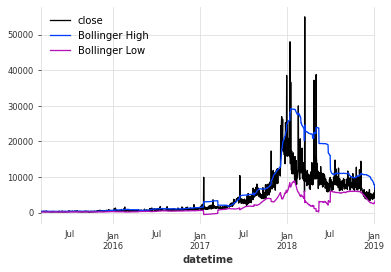

In [94]:
price_df[['close','Bollinger High','Bollinger Low']].plot()


In [95]:
price_df

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position,Market Return,Strategy Return
datetime,,,,,,,,,,
2015-03-02,296.94,737.46,221.77,255.39,297.005333,405.425101,188.585565,-1.0,-0.052356,0.052356
2015-03-03,290.00,1000.00,235.68,292.84,296.315667,404.489620,188.141713,-1.0,0.146638,-0.146638
2015-03-04,336.17,1000.00,213.21,318.55,295.808167,403.576516,188.039817,-1.0,0.087795,-0.087795
2015-03-05,289.73,1000.00,202.11,298.88,294.545500,401.193224,187.897776,-1.0,-0.061749,0.061749
2015-03-06,294.41,766.15,240.96,325.03,295.079333,401.889602,188.269065,-1.0,0.087493,-0.087493
...,...,...,...,...,...,...,...,...,...,...
2019-01-04,4160.00,17765.86,3039.91,4253.74,5215.888833,7754.694356,2677.083311,1.0,-0.250396,-0.250396
2019-01-05,4193.63,49922.62,3103.20,5656.52,5138.482667,7473.680047,2803.285286,1.0,0.329776,0.329776
2019-01-06,5060.00,45000.45,3230.35,6065.13,5135.433000,7467.581429,2803.284571,1.0,0.072237,0.072237


<AxesSubplot:xlabel='datetime'>

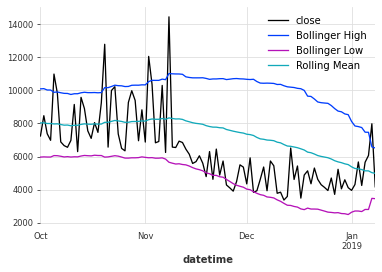

In [96]:
price_df[price_df.index >= '2018-10-01'][['close','Bollinger High','Bollinger Low', 'Rolling Mean']].plot()


### Train LSTM  /Darts

In [97]:
COLS = ['open',	'high',	'low',	'close',	'Rolling Mean',	'Bollinger High',	'Bollinger Low']
dataset_train = price_df[:int(price_df.shape[0]*0.8) ][COLS] 
dataset_test = price_df[int(price_df.shape[0]*0.8):][COLS]

In [98]:
price_df.head()

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position,Market Return,Strategy Return
datetime,,,,,,,,,,
2015-03-02,296.94,737.46,221.77,255.39,297.005333,405.425101,188.585565,-1.0,-0.052356,0.052356
2015-03-03,290.00,1000.00,235.68,292.84,296.315667,404.489620,188.141713,-1.0,0.146638,-0.146638
2015-03-04,336.17,1000.00,213.21,318.55,295.808167,403.576516,188.039817,-1.0,0.087795,-0.087795
2015-03-05,289.73,1000.00,202.11,298.88,294.545500,401.193224,187.897776,-1.0,-0.061749,0.061749
2015-03-06,294.41,766.15,240.96,325.03,295.079333,401.889602,188.269065,-1.0,0.087493,-0.087493


In [99]:
dataset_train.shape

(1127, 7)

In [100]:
price_df

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position,Market Return,Strategy Return
datetime,,,,,,,,,,
2015-03-02,296.94,737.46,221.77,255.39,297.005333,405.425101,188.585565,-1.0,-0.052356,0.052356
2015-03-03,290.00,1000.00,235.68,292.84,296.315667,404.489620,188.141713,-1.0,0.146638,-0.146638
2015-03-04,336.17,1000.00,213.21,318.55,295.808167,403.576516,188.039817,-1.0,0.087795,-0.087795
2015-03-05,289.73,1000.00,202.11,298.88,294.545500,401.193224,187.897776,-1.0,-0.061749,0.061749
2015-03-06,294.41,766.15,240.96,325.03,295.079333,401.889602,188.269065,-1.0,0.087493,-0.087493
...,...,...,...,...,...,...,...,...,...,...
2019-01-04,4160.00,17765.86,3039.91,4253.74,5215.888833,7754.694356,2677.083311,1.0,-0.250396,-0.250396
2019-01-05,4193.63,49922.62,3103.20,5656.52,5138.482667,7473.680047,2803.285286,1.0,0.329776,0.329776
2019-01-06,5060.00,45000.45,3230.35,6065.13,5135.433000,7467.581429,2803.284571,1.0,0.072237,0.072237


In [101]:
series = TimeSeries.from_dataframe(price_df[COLS], value_cols='close', freq='D')

In [102]:
COLS = ['open','high','low','close','Rolling Mean','Bollinger High','Bollinger Low']
dataset_train = price_df[:int(price_df.shape[0]*0.8) ][COLS] 
dataset_test = price_df[int(price_df.shape[0]*0.8):][COLS]

In [103]:
price_df.head()

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position,Market Return,Strategy Return
datetime,,,,,,,,,,
2015-03-02,296.94,737.46,221.77,255.39,297.005333,405.425101,188.585565,-1.0,-0.052356,0.052356
2015-03-03,290.00,1000.00,235.68,292.84,296.315667,404.489620,188.141713,-1.0,0.146638,-0.146638
2015-03-04,336.17,1000.00,213.21,318.55,295.808167,403.576516,188.039817,-1.0,0.087795,-0.087795
2015-03-05,289.73,1000.00,202.11,298.88,294.545500,401.193224,187.897776,-1.0,-0.061749,0.061749
2015-03-06,294.41,766.15,240.96,325.03,295.079333,401.889602,188.269065,-1.0,0.087493,-0.087493


In [104]:
price_df[COLS].describe()

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low
count,1409.000000,1.409000e+03,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000
mean,4137.787097,3.441652e+07,2273.980539,4195.861207,4101.741218,6342.958555,1860.523881
std,5347.575221,1.288580e+09,2614.600353,5479.991956,4863.127435,7928.496827,2208.671640
min,205.380000,4.960200e+02,1.000000,203.000000,276.824500,344.246255,-507.068955
25%,495.380000,2.235140e+03,313.320000,493.880000,530.701667,711.994222,231.021766
50%,1288.090000,6.410260e+03,733.060000,1337.700000,1320.583667,2079.515402,552.919013
75%,6837.320000,3.904725e+04,4509.400000,6876.940000,7960.788000,10450.992321,3095.249310
max,55000.310000,4.836901e+10,14401.950000,54999.450000,19009.738833,29223.564142,9002.981506


In [105]:
pd.isna(price_df[COLS]).sum()

open              0
high              0
low               0
close             0
Rolling Mean      0
Bollinger High    0
Bollinger Low     0
dtype: int64

In [106]:
pd.isnull(price_df[COLS]).sum()

open              0
high              0
low               0
close             0
Rolling Mean      0
Bollinger High    0
Bollinger Low     0
dtype: int64

In [107]:
pd.date_range(start = '2013-05-19', end = '2019-01-08' ).difference(price_df['open'].index)


DatetimeIndex(['2013-05-19', '2013-05-20', '2013-05-21', '2013-05-22',
               '2013-05-23', '2013-05-24', '2013-05-25', '2013-05-26',
               '2013-05-27', '2013-05-28',
               ...
               '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23',
               '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27',
               '2015-02-28', '2015-03-01'],
              dtype='datetime64[ns]', length=652, freq=None)

- Need to fill in these missing values for 2014

In [108]:
price_df = price_df[price_df.index > '2015-01-01']

In [109]:
# create series for each col
open_series = fill_missing_values(TimeSeries.from_series(price_df['open'],  freq='D'))
high_series = fill_missing_values(TimeSeries.from_series(price_df['high'],  freq='D'))
low_series = fill_missing_values(TimeSeries.from_series(price_df['low'],  freq='D'))
close_series = fill_missing_values(TimeSeries.from_series(price_df['close'],  freq='D'))
mean_series = fill_missing_values(TimeSeries.from_series(price_df['Rolling Mean'],  freq='D'))
bh_series = fill_missing_values(TimeSeries.from_series(price_df['Bollinger High'],  freq='D'))
bl_series = fill_missing_values(TimeSeries.from_series(price_df['Bollinger High'],  freq='D'))


# build year and month series:
close_year_series = datetime_attribute_timeseries(open_series, attribute='year')
close_month_series = datetime_attribute_timeseries(open_series, attribute='month')


In [110]:
close_series_transformer = Scaler()
close_series_transformed = close_series_transformer.fit_transform(close_series)

open_series_transformer = Scaler()
open_series_transformed = open_series_transformer.fit_transform(open_series)

high_series_transformer = Scaler()
high_series_transformed = high_series_transformer.fit_transform(high_series)

low_series_transformer = Scaler()
low_series_transformed = low_series_transformer.fit_transform(low_series)

mean_series_transformer = Scaler()
mean_series_transformed = mean_series_transformer.fit_transform(mean_series)

bh_series_transformer = Scaler()
bh_series_transformed = bh_series_transformer.fit_transform(bh_series)

bl_series_transformer = Scaler()
bl_series_transformed = bl_series_transformer.fit_transform(bl_series)


year_series_transformer = Scaler()
year_series_transformed = year_series_transformer.fit_transform(close_year_series)

month_series_transformer = Scaler()
month_series_transformed = month_series_transformer.fit_transform(close_month_series)

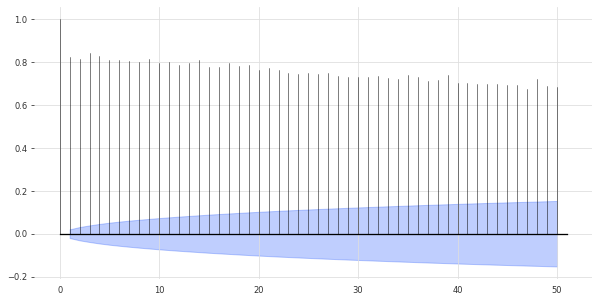

In [111]:
plot_acf(close_series, max_lag=50) # no seasonality


In [112]:
# Create validation
SPLIT_DATE = '2018-01-01'
open_train, open_val = open_series.split_after(pd.Timestamp(SPLIT_DATE))
high_train, high_val = high_series.split_after(pd.Timestamp(SPLIT_DATE))
low_train, low_val = low_series.split_after(pd.Timestamp(SPLIT_DATE))
close_train, close_val = close_series.split_after(pd.Timestamp(SPLIT_DATE))
mean_train, mean_val = mean_series.split_after(pd.Timestamp(SPLIT_DATE))
bh_train, bh_val = bh_series.split_after(pd.Timestamp(SPLIT_DATE))
bl_train, bl_val = bl_series.split_after(pd.Timestamp(SPLIT_DATE))

close_year_train, close_year_val = close_year_series.split_after(pd.Timestamp(SPLIT_DATE))
close_month_train, close_month_val = close_month_series.split_after(pd.Timestamp(SPLIT_DATE))

In [113]:
open_train.start_time(), open_val.end_time()

(Timestamp('2015-03-02 00:00:00', freq='D'),
 Timestamp('2019-01-08 00:00:00', freq='D'))

In [114]:
high_train.start_time(), high_val.end_time()

(Timestamp('2015-03-02 00:00:00', freq='D'),
 Timestamp('2019-01-08 00:00:00', freq='D'))

In [115]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
open_train_transformer = Scaler()
open_train_transformed = open_train_transformer.fit_transform(open_train)
open_val_transformed = open_train_transformer.transform(open_val)

high_transformer = Scaler()
high_train_transformed = high_transformer.fit_transform(high_train)
high_val_transformed = high_transformer.transform(high_val)

low_transformer = Scaler()
low_train_transformed = low_transformer.fit_transform(low_train)
low_val_transformed = low_transformer.transform(low_val)

close_transformer = Scaler()
close_train_transformed = close_transformer.fit_transform(close_train)
close_val_transformed = close_transformer.transform(close_val)

mean_transformer = Scaler()
mean_train_transformed = mean_transformer.fit_transform(mean_train)
mean_val_transformed = mean_transformer.transform(mean_val)

bh_transformer = Scaler()
bh_train_transformed = bh_transformer.fit_transform(bh_train)
bh_val_transformed = bh_transformer.transform(bh_val)

bl_transformer = Scaler()
bl_train_transformed = bl_transformer.fit_transform(bl_train)
bl_val_transformed = bl_transformer.transform(bl_val)




year_transformer = Scaler()
year_train_transformed = year_transformer.fit_transform(close_year_train)
year_val_transformed = year_transformer.transform(close_year_val)

month_transformer = Scaler()
month_train_transformed = bl_transformer.fit_transform(close_month_train)
month_val_transformed = bl_transformer.transform(close_month_val)

In [116]:
open_train_transformed.components

Index(['open'], dtype='object', name='component')

In [117]:
close_train_transformed.describe()

component,close
count,1037.000000
mean,0.053336
std,0.104572
min,0.000000
25%,0.005685
50%,0.014410
75%,0.041975
max,1.000000


In [118]:
# stack our covariates train
all_covariates_transformed_train = open_train_transformed.stack(high_train_transformed).stack(low_train_transformed).stack(mean_train_transformed).stack(
    bh_train_transformed).stack(bl_train_transformed).stack(close_month_train).stack(close_year_train)



# stack our covariates val. NOt using this
# all_covariates_val = open_val_transformed.stack(high_val_transformed).stack(low_val_transformed).stack(mean_val_transformed).stack(
#     bh_val_transformed).stack(bl_val_transformed)


# stack our covariates all
all_covariates_series_stacked = open_series_transformed.stack(high_series_transformed).stack(low_series_transformed).stack(mean_series_transformed).stack(
    bh_series_transformed).stack(bl_series_transformed).stack(year_series_transformed).stack(month_series_transformed)



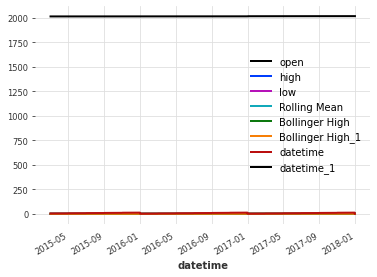

In [119]:
all_covariates_transformed_train.plot()

In [ ]:
model_close = NBEATSModel(input_chunk_length=30, output_chunk_length=14, n_epochs=100, random_state=0)


model_close.fit(series = close_train, past_covariates = [all_covariates_transformed_train],  verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
model_close_rnn = BlockRNNModel(input_chunk_length=30, output_chunk_length=14, n_epochs=100, random_state=0)


model_close_rnn.fit(series = close_train, past_covariates = [all_covariates_transformed_train],  verbose=True)

In [ ]:
deeptcn = TCNModel(
    n_epochs=100,
    input_chunk_length=30,
    output_chunk_length=14,
    likelihood=GaussianLikelihoodModel(), random_state=0)

deeptcn.fit(series = close_train, past_covariates = [all_covariates_transformed_train],  verbose=True)

In [ ]:
pred_close_nbeats = model_close.predict(n=14, series=close_train, past_covariates = [all_covariates_transformed_train])
pred_close_rnn = model_close_rnn.predict(n=14, series=close_train, past_covariates = [all_covariates_transformed_train])
pred_close_tcn = deeptcn.predict(n=14, series=close_train, past_covariates = [all_covariates_transformed_train])

In [ ]:
pred_close_tcn.plot(label='forecast TCN')

MAPE NBEATS = 55.79%
MAPE RNN = 99.77%
MAPE TCN = 38.06%


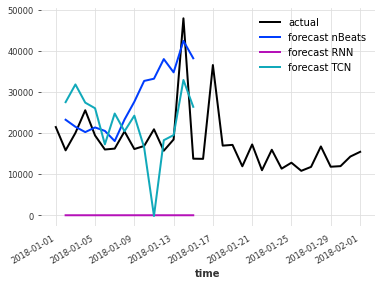

In [132]:
# compare models
close_series.slice(pd.to_datetime("2018-01-01"), pd.to_datetime("2018-02-01")).plot(label='actual')
plt.title('NBeats model')
pred_close_nbeats.plot(label='forecast nBeats')
pred_close_rnn.plot(label='forecast RNN')
pred_close_tcn.plot(label='forecast TCN')
plt.legend();
print('MAPE NBEATS = {:.2f}%'.format(mape(close_series.slice(pd.to_datetime("2018-01-01"), pd.to_datetime("2018-01-15"))  ,
                                          pred_close_nbeats)))
print('MAPE RNN = {:.2f}%'.format(mape(close_series.slice(pd.to_datetime("2018-01-01"), pd.to_datetime("2018-01-15")),
                                       pred_close_rnn)))
print('MAPE TCN = {:.2f}%'.format(mape(close_series.slice(pd.to_datetime("2018-01-01"), pd.to_datetime("2018-01-15")),
                                       pred_close_tcn)))

## Backtest

In [ ]:
# slice for data the model hasn't seen
backtest_nbeats = model_close.historical_forecasts(close_series.slice(pd.to_datetime("2018-01-01"), pd.to_datetime("2019-01-01")) ,
                                              past_covariates=all_covariates_series_stacked,
                                              start=0.5,
                                              forecast_horizon=14,
                                              stride=1,
                                              retrain=False,
                                              verbose=True)

In [ ]:

backtest_rnn = model_close_rnn.historical_forecasts(close_series.slice(pd.to_datetime("2018-01-01"), pd.to_datetime("2019-01-01")),
                                              past_covariates=all_covariates_series_stacked,
                                              start=0.5,
                                              forecast_horizon=14,
                                              stride=1,
                                              retrain=False,
                                              verbose=True)

In [ ]:

backtest_tcn = deeptcn.historical_forecasts(close_series.slice(pd.to_datetime("2018-01-01"), pd.to_datetime("2019-01-01")),
                                              past_covariates=all_covariates_series_stacked,
                                              start=0.5,
                                              forecast_horizon=14,
                                              stride=1,
                                              retrain=False,
                                              verbose=True)

In [ ]:
close_series.slice(pd.to_datetime("2018-01-01"), pd.to_datetime("2019-01-01")).plot(label='actual')

backtest_nbeats.plot(label='backtest nbeats')
backtest_rnn.plot(label='backtest rnn')
backtest_tcn.plot(label ='backtest tcn')

plt.legend();
print('MAP NbeatsE (using covariates) = {:.2f}%'.format(mape(close_series, backtest_nbeats)))
print('MAPE RNN (using covariates) = {:.2f}%'.format(mape(close_series, backtest_rnn)))


sqrt(mse(close_series, close_transformer.inverse_transform(backtest_nbeats)))

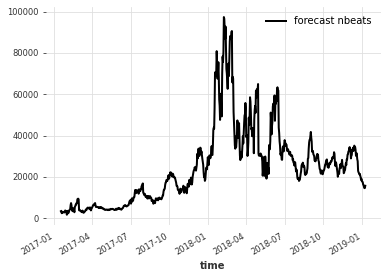

In [54]:
backtest_nbeats.plot(label='forecast nbeats')

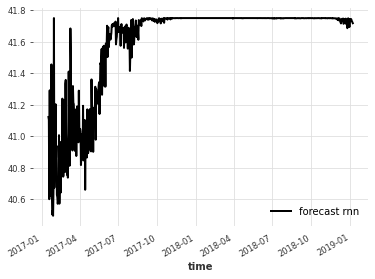

In [55]:
backtest_rnn.plot(label='forecast rnn')

## Working on a strategy

In [56]:
# create a new column in the DataFrame to hold positions information
price_df['Position'] = None

# fill our position column based on the following rules:
#     * set to short (-1) when the price hits the upper band
#     * set to long (1) when it hits the lower band       
mode = 'open'
for index in range(len(price_df)):
    if index == 0:
        continue

    row = price_df.iloc[index]
    prev_row = price_df.iloc[index - 1]

    # long?
    if mode == 'open' and row['close'] < row['Bollinger Low'] and prev_row['close'] > prev_row['Bollinger Low']:
        price_df.iloc[index, price_df.columns.get_loc('Position')] = 1
        mode = 'close'

    # short?
    if mode == 'close' and row['close'] > row['Bollinger High'] and prev_row['close'] < prev_row['Bollinger High']:
        price_df.iloc[index, price_df.columns.get_loc('Position')] = -1
        mode = 'open'

In [57]:
price_df.dropna(subset=['Position'])


,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position
datetime,,,,,,,,
2015-01-05,290.36,1199.76,180.49,293.00,420.663333,533.813687,307.512980,1
2015-01-30,247.99,1219.51,199.81,617.28,354.166833,468.060049,240.273618,-1
2015-02-03,252.58,800.00,147.21,216.59,343.229000,460.663371,225.794629,1
2015-02-17,263.81,660.50,202.71,555.56,318.369833,444.970944,191.768723,-1
2015-04-18,318.27,1000.00,191.29,215.68,302.123000,379.150007,225.095993,1
2015-05-19,247.18,1000.00,197.60,462.96,288.471833,373.826620,203.117047,-1
2015-09-30,271.56,2617.80,201.41,203.00,304.569500,394.286473,214.852527,1
2015-10-03,248.57,2617.80,191.87,407.83,299.009833,377.505505,220.514162,-1
2018-11-19,5555.01,27342.33,3358.78,4789.28,7868.900833,10724.559887,5013.241780,1


## Visualize position

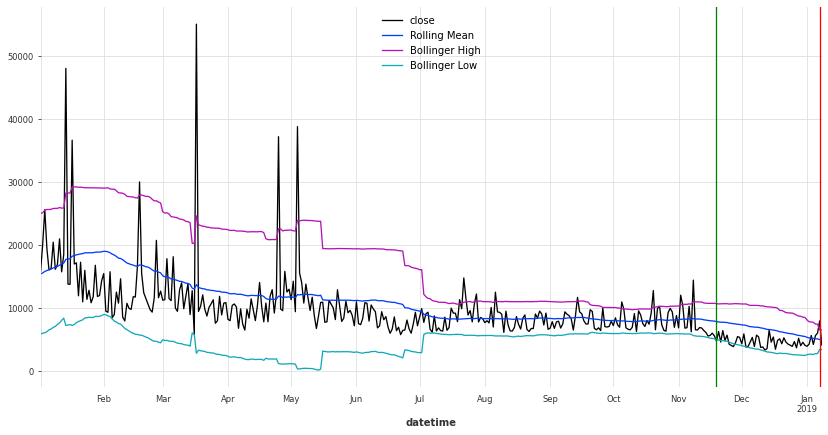

In [ ]:

price_df[price_df.index > '2018-01-01'][['close', 'Rolling Mean', 'Bollinger High','Bollinger Low']].plot(figsize=(14, 7))

for index, pos in price_df[price_df.index > '2018-01-01'].dropna(subset=['Position'])['Position'].iteritems():
    plt.axvline(index, color='green' if pos == 1 else 'red')

<AxesSubplot:xlabel='datetime'>

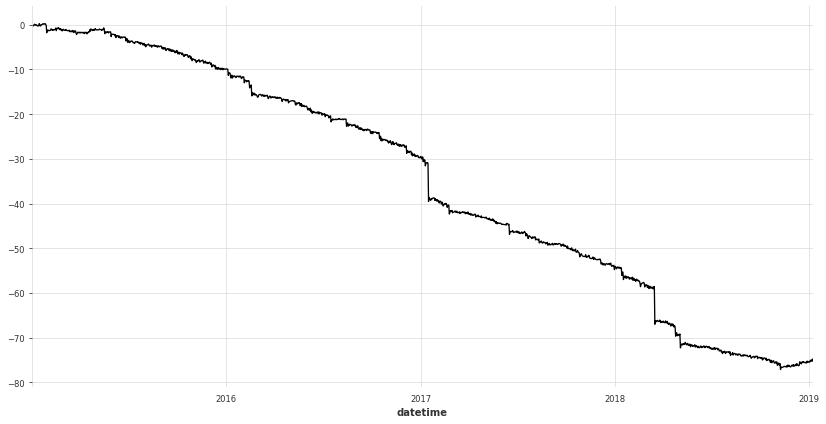

In [ ]:
# forward fill our Position column to replace "None" values with the correct buy/sell 
# operations to represent the "holding" of our position forward through time
# price_df.dropna(inplace=True)
price_df['Position'].fillna(method='ffill', inplace=True)

# calculate the daily market return and multiply that by the position to determine strategy returns
price_df['Market Return'] = price_df['close'].pct_change()
price_df['Strategy Return'] = price_df['Market Return'] * price_df['Position']

# plot the strategy returns
price_df['Strategy Return'].cumsum().plot(figsize=(14, 7))

In [ ]:
price_df

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position,Market Return,Strategy Return
datetime,,,,,,,,,,
2015-01-02,791.14,1262.63,277.40,334.22,423.651167,532.997706,314.304628,NaN,NaN,NaN
2015-01-03,367.34,1206.43,263.71,349.00,423.101667,533.111861,313.091472,NaN,0.044222,NaN
2015-01-04,367.38,1200.48,234.51,374.64,422.618500,532.967095,312.269905,NaN,0.073467,NaN
2015-01-05,290.36,1199.76,180.49,293.00,420.663333,533.813687,307.512980,1.0,-0.217916,-0.217916
2015-01-06,255.54,1960.78,235.44,346.19,415.600167,520.244573,310.955760,1.0,0.181536,0.181536
...,...,...,...,...,...,...,...,...,...,...
2019-01-04,4160.00,17765.86,3039.91,4253.74,5215.888833,7754.694356,2677.083311,1.0,-0.250396,-0.250396
2019-01-05,4193.63,49922.62,3103.20,5656.52,5138.482667,7473.680047,2803.285286,1.0,0.329776,0.329776
2019-01-06,5060.00,45000.45,3230.35,6065.13,5135.433000,7467.581429,2803.284571,1.0,0.072237,0.072237


# Finding a better configuration¶


In [ ]:
price_df

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position,Market Return,Strategy Return
datetime,,,,,,,,,,
2015-01-02,791.14,1262.63,277.40,334.22,423.651167,532.997706,314.304628,NaN,NaN,NaN
2015-01-03,367.34,1206.43,263.71,349.00,423.101667,533.111861,313.091472,NaN,0.044222,NaN
2015-01-04,367.38,1200.48,234.51,374.64,422.618500,532.967095,312.269905,NaN,0.073467,NaN
2015-01-05,290.36,1199.76,180.49,293.00,420.663333,533.813687,307.512980,1.0,-0.217916,-0.217916
2015-01-06,255.54,1960.78,235.44,346.19,415.600167,520.244573,310.955760,1.0,0.181536,0.181536
...,...,...,...,...,...,...,...,...,...,...
2019-01-04,4160.00,17765.86,3039.91,4253.74,5215.888833,7754.694356,2677.083311,1.0,-0.250396,-0.250396
2019-01-05,4193.63,49922.62,3103.20,5656.52,5138.482667,7473.680047,2803.285286,1.0,0.329776,0.329776
2019-01-06,5060.00,45000.45,3230.35,6065.13,5135.433000,7467.581429,2803.284571,1.0,0.072237,0.072237


In [65]:
class BollingerBandsSimulator:

    def __init__(self, df_original, from_date, period, window, no_of_std, figsize=None):
        self.df = df_original
        self.from_date = from_date
        self.period = period
        self.window = window
        self.no_of_std = no_of_std
        self.figsize = figsize
        
        self.ml_model = None

        
        
    def _scale_time_series(self, input_df, train_cols=['open', 'high', 'low', 'Bollinger High','Rolling Mean'],
                           pred_col ='close', time_cols = ['year', 'month', 'day']):
        ts_transformers = {}
        ts_stacked_series = None
        train_series = None
        for col  in train_cols:
            transformer = Scaler()
            transformed_series = transformer.fit_transform(fill_missing_values(TimeSeries.from_series(input_df[col],  freq=self.period)))
            ts_transformers[col] = transformer    

            if ts_stacked_series:
                ts_stacked_series = ts_stacked_series.stack(transformed_series)

            else:
                ts_stacked_series = transformed_series
            
        
        # build year and month series:
        for col in time_cols:
            transformer = Scaler()
            transformed_series = transformer.fit_transform(datetime_attribute_timeseries(ts_stacked_series, attribute=col))
            ts_transformers[col] = transformer    

            ts_stacked_series = ts_stacked_series.stack(transformed_series)
             

        return ts_transformers, ts_stacked_series, TimeSeries.from_series(input_df[pred_col],  freq=self.period)
    
    def __check_ml_prediction(self, end_time, input_chunk_length=40, output_chunk_length=7, epochs=2) -> float:
        """train ML model to predict price movement over the next 7 days"""
        
        if not self.ml_model: # define model once, retrain incrementally
            self.ml_model = NBEATSModel(input_chunk_length=input_chunk_length, 
                                      output_chunk_length=output_chunk_length, n_epochs=epochs, random_state=0)

        training_df = self.df[self.df.index <= pd.to_datetime(end_time)]
        
        ts_transformers, ts_stacked_series, train_close_series = self._scale_time_series(training_df)
        

        # train the model
        self.ml_model.fit(series = train_close_series, past_covariates = [ts_stacked_series],  verbose=True)

        
        plt.show()
        pred_close = self.ml_model.predict(n=output_chunk_length, 
                                                 series=train_close_series, past_covariates = [ts_stacked_series])
        
        return pred_close.last_value()
        
    
    def _build_candles_dataframe(self):
        self.df = self.df.loc[self.from_date:, ["price"]].copy()
        self.df = self.df["price"].resample(self.period).ohlc()
                
    def _build_bollinger_bands(self):
        rolling_mean = self.df['close'].rolling(self.window).mean()
        rolling_std = self.df['close'].rolling(self.window).std()

        self.df['Rolling Mean'] = rolling_mean
        self.df['Bollinger High'] = rolling_mean + (rolling_std * self.no_of_std)
        self.df['Bollinger Low'] = rolling_mean - (rolling_std * self.no_of_std)

    def _calculate_positions(self):
        self.df['Position'] = None
        self.df['Mode'] = None
        self.number_of_trades = 0
        buy_has_crossed_mean = False
        short_has_crossed_mean = False
        self.ml_prediction_date_and_price = {}


        mode = 'no_position'
        
        for index in range(len(self.df)):
            if index == 0:
                self.df.iloc[index, self.df.columns.get_loc('Mode')] =  mode
                continue

            row = self.df.iloc[index]
            prev_row = self.df.iloc[index - 1]
                                                           
            
            # get out of position if price crosses mean
            # (if mode == 'open' or mode == 'no_position' ) and 
            if mode == 'buy'  and row['close'] > row['Rolling Mean']:
                buy_has_crossed_mean = True
                
            if mode == 'short'  and row['close'] < row['Rolling Mean']:
                short_has_crossed_mean = True

            # open -> no_position? no position is below running mean
            # or, if we are above the top band (mean reversion)
            if mode == 'buy'  and ((row['close'] < row['Rolling Mean'] and buy_has_crossed_mean) or (row['close'] > row['Bollinger High'])):
                # check ML predicted trend as well
                ml_7_day_pred = self.__check_ml_prediction(row.name)
                if ml_7_day_pred < row['Rolling Mean']:
                    print("-------")
                    print('buy_to_no_position')
                    print(ml_7_day_pred, 'ml_7_day_pred')
                    print(row['Rolling Mean'], 'mean')
                

                    self.df.iloc[index, self.df.columns.get_loc('Position')] = 1

                    if index +1  == len(self.df):
                        self.df.iloc[index, self.df.columns.get_loc('Position')] = 0 
                    else:
                        self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = 0 # for pct change it does a ffilll. ffill with zeros
                    self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'buy_to_no_position'

                    mode = 'no_position'
                    buy_has_crossed_mean = False
            
            # close -> no_position? no position if above running mean
            # or, if we are below the bottom band (mean reversion)
            elif mode == 'short'  and ((row['close'] > row['Rolling Mean'] and short_has_crossed_mean) or (row['close'] < row['Bollinger Low'])):
                
                # check ML predicted trend as well
                ml_7_day_pred = self.__check_ml_prediction(row.name)
                if ml_7_day_pred > row['Rolling Mean']:
                    print("-------")
                    print('buy_to_no_position')
                    print(ml_7_day_pred, 'ml_7_day_pred')
                    print(row['Rolling Mean'], 'mean')
                    
                    self.df.iloc[index, self.df.columns.get_loc('Position')] = -1
                    if index +1  == len(self.df):
                        self.df.iloc[index, self.df.columns.get_loc('Position')] = 0 
                    else:
                        self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = 0 # for pct change it does a ffilll. ffill with zeros
                    self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'short_to_no_position'
                    mode = 'no_position'
                    short_has_crossed_mean = False

            # buy check with ML model
            elif mode == 'no_position' and row['close'] < row['Bollinger Low'] and prev_row['close'] > prev_row['Bollinger Low']:
                print('----------')
                print('buy')
                ml_7_day_pred = self.__check_ml_prediction(row.name)
                
                print(ml_7_day_pred, 'ml prediction 7 day')
                print(row.name, 'current date')
                print(row['Rolling Mean'], 'mean')
                
                if ml_7_day_pred > row['Rolling Mean']:
                    print('pred 7 day higher than mean taking position')
                    self.ml_prediction_date_and_price[row.name + timedelta(days=7)] = ml_7_day_pred #?? will this work
                
                    self.df.iloc[index, self.df.columns.get_loc('Position')] = 0 # buy. add one to index so that pct_change works

                    if index +1  == len(self.df):
                        self.df.iloc[index, self.df.columns.get_loc('Position')] = 1 
                    else:
                        self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = 1 # buy. add one to index so that pct_change works
                    self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'buy'
                    self.number_of_trades  +=1
                    mode = 'buy'     

            # short?
            elif mode == 'no_position' and  row['close'] > row['Bollinger High'] and prev_row['close'] < prev_row['Bollinger High']:
                print('----------')
                print('short')
                ml_7_day_pred = self.__check_ml_prediction(row.name)
                
                print(ml_7_day_pred, 'ml prediction 7 day')
                print(row.name, 'current date')
                print(row['Rolling Mean'], 'mean')
                
                if ml_7_day_pred < row['Rolling Mean']:
                    print('pred 7 day lower than mean taking position')
                    self.ml_prediction_date_and_price[row.name + timedelta(days=7)] = ml_7_day_pred 

                    self.df.iloc[index, self.df.columns.get_loc('Position')] = 0 #  short starts at the end of the day. Calculate pct_change starting tomorrow
                    self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = -1 #  short starts at the end of the day. Calculate pct_change starting tomorrow
                    if index +1  == len(self.df):
                        self.df.iloc[index, self.df.columns.get_loc('Position')] = -1
                    else:
                        self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = -1 # buy. add one to index so that pct_change works
                    self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'short'
                    self.number_of_trades  +=1
                    mode = 'short' 
                       
            else:
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = mode
        
    def _calculate_returns(self):
        
        self.df['Original Position'] = self.df['Position']
        self.df['Position'].fillna(method='ffill', inplace=True)
        self.df['Market Return'] = self.df['close'].pct_change()
        self.df['Strategy Return'] = self.df['Market Return'] * self.df['Position']

    def _plot_returns(self):
        self.df['Strategy Return'].cumsum().plot(figsize=self.figsize)
        

    def simulate(self):
        self._build_candles_dataframe()
        self._build_bollinger_bands()
        self._calculate_positions()
        self._calculate_returns()
        self._plot_returns()

        return (
            self.period, 
            self.window, 
            self.no_of_std, 
            self.df['Strategy Return'].sum(),
            self.number_of_trades
        )

In [66]:

simulator = BollingerBandsSimulator(
    data, 
    from_date="2017-1-01", 
    period="24H", 
    window=30, 
    no_of_std=1.5
)
simulator.simulate()

----------
short


ValueError: __len__() should return >= 0

In [67]:
simulator.df['Strategy Return'].sum() #try again 96% return, 16 trades, run again

1.4530294934693264

In [190]:
#again 96% return, 16 trades, run again from 2017-01-01 to 2019-01-01 

In [68]:
simulator.ml_prediction_date_and_price

{Timestamp('2017-05-01 00:00:00', freq='24H'): 1473.8524987770911,
 Timestamp('2017-07-26 00:00:00', freq='24H'): 3255.6443444959755,
 Timestamp('2017-08-05 00:00:00', freq='24H'): 2839.6704585011753,
 Timestamp('2017-09-29 00:00:00', freq='24H'): 4669.96289614309,
 Timestamp('2018-04-29 00:00:00', freq='24H'): 7415.438429635469,
 Timestamp('2018-10-12 00:00:00', freq='24H'): 6155.95929178983,
 Timestamp('2018-11-15 00:00:00', freq='24H'): 8240.897704521058,
 Timestamp('2018-12-21 00:00:00', freq='24H'): 4717.695279694666}

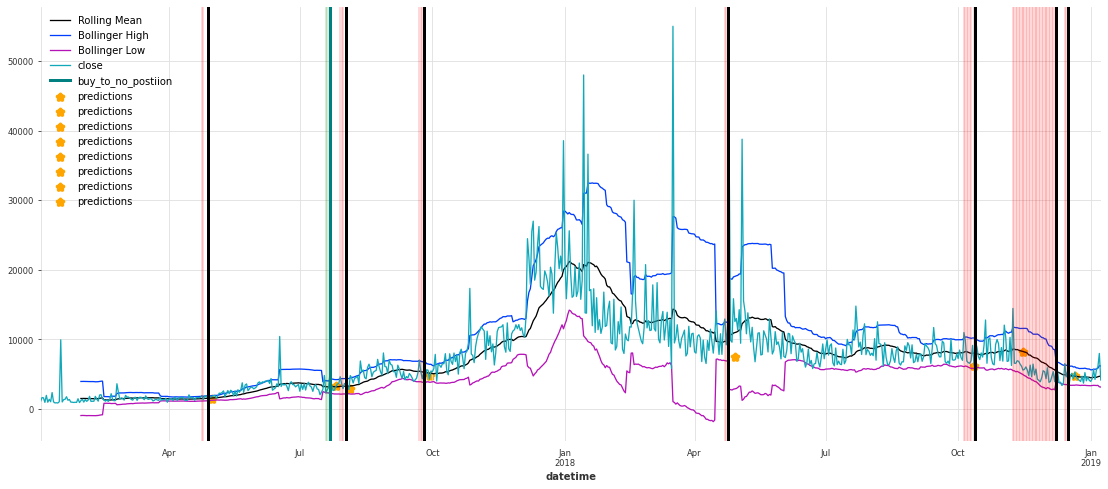

In [70]:
DATE_FILTER = '2017-1-01'
simulator.df[simulator.df.index > DATE_FILTER ]  [['Rolling Mean', 'Bollinger High', 'Bollinger Low', 'close']].plot(figsize=(19,8))

prev_pos = None
for index, pos in simulator.df[simulator.df.index > DATE_FILTER ]['Mode'].iteritems():
    if pos == "short":
        plt.axvline(index, color='red', linewidth=.3)
    if pos == "buy":
        plt.axvline(index, color='green', linewidth=.3)
    if pos == 'short_to_no_position':
        plt.axvline(index, color='black', linewidth=3)
    if pos == 'buy_to_no_position':
        plt.axvline(index, color='teal', linewidth=3, label = 'buy_to_no_postiion')
#     if pos == 0:
#         plt.axvline(index, color='black')

for key,val in simulator.ml_prediction_date_and_price.items():
    plt.scatter(key, val, marker="*", linewidths=4, color='orange', label='predictions')

plt.legend()

In [167]:
simulator.df[simulator.df.index >= "2018-11-1"].head(30)


,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position,Mode,Original Position,Market Return,Strategy Return
datetime,,,,,,,,,,,,
2018-11-01,6492.09,69672.53,4727.36,6876.94,8224.051333,10692.397545,5755.705122,0.0,no_position,None,-0.220857,-0.000000
2018-11-02,12692.67,50839.93,4762.88,12055.25,8379.855000,11048.173423,5711.536577,0.0,short,0,0.752996,0.000000
2018-11-03,6820.34,48896.89,4746.44,10360.21,8492.416000,11183.773768,5801.058232,-1.0,short,-1,-0.140606,0.140606
2018-11-04,6777.27,40000.00,4847.58,6833.06,8353.918000,10986.253100,5721.582900,-1.0,short,None,-0.340452,0.340452
2018-11-05,8348.51,250000.00,4547.55,6912.22,8256.766000,10883.583852,5629.948148,-1.0,short,None,0.011585,-0.011585
2018-11-06,6584.11,70546.74,4608.14,10300.89,8370.540000,11025.498122,5715.581878,-1.0,short_to_no_position,-1,0.490243,-0.490243
2018-11-07,6673.77,71540.99,4904.95,6248.11,8356.716333,11034.699883,5678.732784,0.0,no_position,0,-0.393440,-0.000000
2018-11-08,7214.81,83816.68,5149.34,14446.86,8619.577000,11724.131280,5515.022720,0.0,short,0,1.312197,0.000000
2018-11-09,6470.76,35999.71,4840.56,6573.01,8606.153000,11729.155839,5483.150161,-1.0,short,-1,-0.545022,0.545022


In [168]:
simulator.df['Mode'].value_counts()

no_position             537
short                   128
short_to_no_position     17
buy                      13
buy_to_no_position        2
Name: Mode, dtype: int64

# Brute force some configurations¶


In [19]:
 # generate a linear space of value values for each parameter in the configuration
# a take some random samples from them.
# for example the first one creates a vector of 5 evenly spaced integer values ranging from 10 to 100
windows = np.linspace(7, 90, 8, dtype=int)
stds = np.linspace(1.5, 2, 2)
periods = np.linspace(15 ,240, 6, dtype=int)

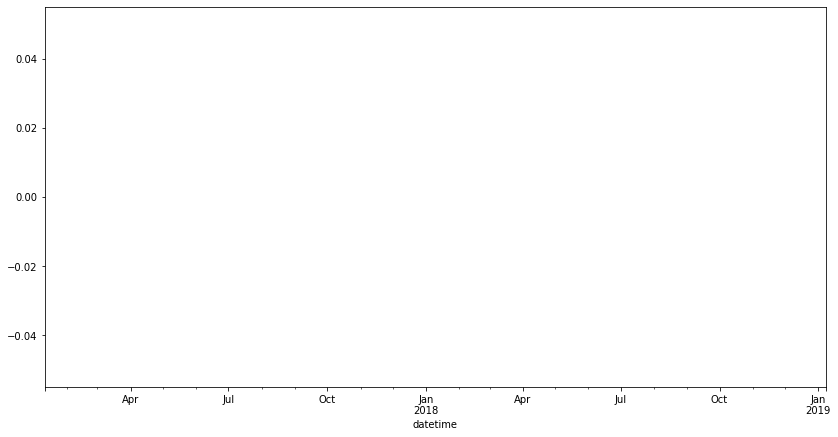

In [20]:
# iterate through them, running the strategy function each time and collecting returns
# (this might take some time)
simulations = []
result_df = pd.DataFrame({
    'period': [], 
    'window': [],
    'no_of_std': [],
    'result': []
})
for window in windows:
    for std in stds:
        for period in periods:
            simulator = BollingerBandsSimulator(
                data, 
                from_date="2017-01-11", 
                period="{}min".format(period), 
                window=window, 
                no_of_std=std,
                figsize=(14, 7)
            )
            period, window, no_of_std, result, total_trades = simulator.simulate()
            result_df = result_df.append({
                'period': period, 
                'window': window, 
                'no_of_std': no_of_std, 
                'result': result,
                'total_trades': total_trades
            }, ignore_index=True)
            simulations.append(simulator)

In [23]:
result_df.sort_values(by='result').tail(15) # Hours results in 1-2 trades. Test minutes

,period,window,no_of_std,result,total_trades
37,60min,42.0,1.5,0.0,0.0
36,15min,42.0,1.5,0.0,0.0
35,240min,30.0,2.0,0.0,0.0
34,195min,30.0,2.0,0.0,0.0
33,150min,30.0,2.0,0.0,0.0
32,105min,30.0,2.0,0.0,0.0
31,60min,30.0,2.0,0.0,0.0
30,15min,30.0,2.0,0.0,0.0
29,240min,30.0,1.5,0.0,0.0
28,195min,30.0,1.5,0.0,0.0


In [22]:
result_df.sort_values(by='result').tail(15).mean()

/var/folders/0r/jkhwtgvx0wb9vrk6xn4bmz2m0000gn/T/ipykernel_85509/3784085997.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  result_df.sort_values(by='result').tail(15).mean()


window          39.600000
no_of_std        1.766667
result           0.000000
total_trades     0.000000
dtype: float64

In [ ]:
WINNING_STRATEGY_INDEX = 30

### Look at the trading pattern for a winning strategy

In [ ]:
simulations[WINNING_STRATEGY_INDEX].df['Strategy Return'].cumsum()

datetime
2018-01-11 00:00:00         NaN
2018-01-11 06:40:00         NaN
2018-01-11 13:20:00         NaN
2018-01-11 20:00:00         NaN
2018-01-12 02:40:00         NaN
                         ...   
2019-01-07 02:40:00    2.798846
2019-01-07 09:20:00    3.080088
2019-01-07 16:00:00    3.041177
2019-01-07 22:40:00    3.071222
2019-01-08 05:20:00    3.091579
Freq: 400T, Name: Strategy Return, Length: 1305, dtype: float64

<AxesSubplot:xlabel='datetime'>

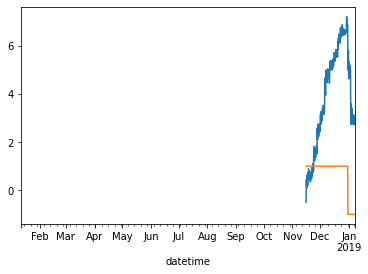

In [ ]:
simulations[WINNING_STRATEGY_INDEX].df['Strategy Return'].cumsum().plot()
simulations[WINNING_STRATEGY_INDEX].df['Position'].plot()

<AxesSubplot:xlabel='datetime'>

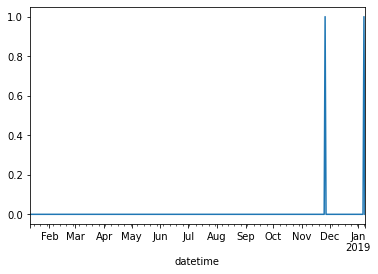

In [162]:
simulations[WINNING_STRATEGY_INDEX].df['Number of Trades'].plot()